In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [3]:
data_path = '/home/lefteris/Desktop/trajectories/data/geodata/year=2018_withConfidenceScore/month=09/day=15/country=gbr'

In [4]:
import re

def get_date_from_data_path(path):
    date = ""
    for idx, val in enumerate(path.rsplit('=', 4)):
        if idx!=0 and idx!=4:
            date+= re.findall(r'\d+', val)[0]+"-"
        elif idx == 4:
            date+= val
    return date

html_name =get_date_from_data_path(data_path)
html_name

'2018-09-15-gbr'

In [5]:
df = pd.read_parquet(data_path + "/part-00000-9fd591f7-74b7-4729-8078-6a38b32a333c-c000.snappy.parquet", engine='pyarrow')

In [6]:
df.dtypes

device_id     object
latitude     float64
longitude    float64
st_ts          int64
nd_ts          int64
dtype: object

In [1]:
df.head()

In [8]:
# # read all files in dir

# all_files = glob.glob(path + "/*.snappy.parquet")

# lista = []
# cnr = 0
# for filename in all_files:
#     try:
#         cnr +=1
#         df = pd.read_parquet(filename,columns=['device_id'], engine='pyarrow')
#         lista.append(df)
#     except:
#         pass

# df_all = pd.concat(lista, axis=0, ignore_index=True)

In [9]:
print("Size of dataframe: ",len(df))

# how many unique device ids in df
list_of_device_ids = df.device_id.unique().tolist()
print("Unique device ids: ", len(list_of_device_ids))

Size of dataframe:  105798
Unique device ids:  10416


### Add the nd_ts for every device id that does not have it in its st_ts

In [10]:
# Single Core groupby
# g = df.groupby(['device_id'])
# for i in list_of_device_ids:
#     dev_1 = g.get_group(i)
#     for index, value in dev_1.iterrows():
#         if value['nd_ts'] not in dev_1.st_ts.unique():
#             df = df.append({'device_id': i,'latitude':value['latitude'],'longitude':value['longitude'], 'st_ts':value['nd_ts'],'nd_ts':0}, ignore_index=True)

In [11]:
def add_nd_ts_to_st_ts(df):
    df1 = df[["device_id","latitude","longitude","st_ts"]]
    df2 = df[["device_id","latitude","longitude","nd_ts"]]
    df2.rename(columns={"nd_ts":"st_ts"},  inplace=True)
    df_cd = pd.concat([df1, df2])
    df_cd.drop_duplicates(subset=['device_id','latitude','longitude', 'st_ts'], keep='first', inplace=True)
    return df_cd

In [12]:
df_more = add_nd_ts_to_st_ts(df)

/home/lefteris/anaconda3/envs/sessions/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [13]:
print("Size of dataframe with added st_ts: ",len(df_more))

Size of dataframe with added st_ts:  142194


### Parallelize convert unix ms into datetime and seconds

In [14]:
from multiprocessing import cpu_count
nCores = cpu_count() #Number of CPU cores on your system
import dask.dataframe as dd
from dask.multiprocessing import get

In [15]:
daskdf = dd.from_pandas(df_more, npartitions=nCores)
#daskdf

In [16]:
def unix_to_datetime(unix):
    return pd.to_datetime(round(unix/1000), unit='s').time()

def datetime_to_seconds(datetime):
    return (datetime.hour * 60 + datetime.minute) * 60 + datetime.second

def apply_value_to_datetime(df):
#     df['d_ts'] = df['nd_ts']-df['st_ts']
    df['datetime_st_ts'] = df['st_ts'].apply(unix_to_datetime)
#     df['con_nd_ts'] = df['nd_ts'].apply(value_to_datetime)
#     df['con_d_ts'] = df['d_ts'].apply(value_to_datetime)
    df['sec_st_ts'] = df['datetime_st_ts'].apply(datetime_to_seconds)
    return df

In [17]:
ddf_out = daskdf.map_partitions(apply_value_to_datetime)

In [18]:
result = ddf_out.compute()

In [2]:
result.head()

In [20]:
df_more_time = result.copy()

In [3]:
df_more_time.head()

###  0 filter: remove points where lat and lon are 0

In [22]:
df_no00 = df_more_time[(df_more_time['latitude'] != 0) & (df_more_time['longitude'] != 0)]

In [23]:
print("{} removed".format(len(df_more_time[(df_more_time['latitude'] == 0) & (df_more_time['longitude'] == 0)])))
print("{} points in dataframe with added st_ts and no lat=0,lon=0".format(len(df_no00)))

83 removed
142111 points in dataframe with added st_ts and no lat=0,lon=0


### Find duplicate latitude and longitude and timestamps for the same device id

In [24]:
# drop the rows where the lat and long are the same and the same device id and starting timestamp
print("After the convertion of unix ms to time:")

df_noDupl = df_no00.drop_duplicates(subset=['device_id','latitude','longitude', 'datetime_st_ts'], keep='first', inplace=False)
df_noDupl =df_noDupl.sort_values(by=['device_id', 'st_ts']).reset_index(drop=True)
print("\nSize of dataframe no duplicates: ",len(df_noDupl))
print("More duplicates due to rounded datetime")

After the convertion of unix ms to time:

Size of dataframe no duplicates:  118689
More duplicates due to rounded datetime


### Add distance and speed to successor point 

In [25]:
# distance in meters
# speed in m/s
df_noDupl['b_dist'] = 0
df_noDupl['b_speed'] = 0
df_noDupl['a_dist'] = 0
df_noDupl['a_speed'] = 0

In [4]:
df_noDupl.head()

In [27]:
len(df_noDupl)

118689

In [28]:
df_noDupl.columns

Index(['device_id', 'latitude', 'longitude', 'st_ts', 'datetime_st_ts',
       'sec_st_ts', 'b_dist', 'b_speed', 'a_dist', 'a_speed'],
      dtype='object')

### Calculate distance and speed between points of the same device ids

In [29]:
# for measuring distance between points
import geopy.distance
from math import radians, sin, cos, acos

def distance_2points(coords_1, coords_2):
#     coords_1 = (52.2296756, 21.0122287)
#     coords_2 = (52.406374, 16.9251681)
    return geopy.distance.distance(coords_1, coords_2).m

def distance_2points_math(coords_1_lat,coords_1_lon, coords_2_lat,coords_2_lon ):
#     coords_1 = (52.2296756, 21.0122287)
#     coords_2 = (52.406374, 16.9251681)
    #return geopy.distance.distance(coords_1, coords_2).km
    slat = radians(float(coords_1_lat))
    slon = radians(float(coords_1_lon))
    elat = radians(float(coords_2_lat))
    elon = radians(float(coords_2_lon))
    return 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

def df_distance_speed_2pnts(df):
    dff = df.reset_index(drop=True)
    dff['group_index']=0
    for i in range(len(dff)):
        dff.loc[i,'group_index']=i # for internal index
        if i!= len(dff)-1 and i!=0:
            coords0_lon = dff.loc[i-1,'longitude']
            coords0_lat = dff.loc[i-1,'latitude']
            coords1_lon = dff.loc[i,'longitude']
            coords1_lat = dff.loc[i,'latitude']
            coords2_lon = dff.loc[i+1,'longitude']
            coords2_lat = dff.loc[i+1,'latitude']
            
            dff.loc[i,'a_dist' ] = distance_2points((coords1_lat,coords1_lon), (coords2_lat,coords2_lon))
            dff.loc[i,'b_dist' ] = distance_2points((coords1_lat,coords1_lon), (coords0_lat,coords0_lon))
            
            if (dff.loc[i,'sec_st_ts'] - dff.loc[i-1,'sec_st_ts'])!=0:
                dff.loc[i,'b_speed' ] = dff.loc[i,'b_dist' ]/((dff.loc[i,'sec_st_ts'] - dff.loc[i-1,'sec_st_ts']))
            elif (dff.loc[i,'sec_st_ts'] - dff.loc[i-1,'sec_st_ts'])==0:
                dff.loc[i,'b_speed' ] = -1
            
            if (dff.loc[i+1,'sec_st_ts']-dff.loc[i,'sec_st_ts'])!=0:
                dff.loc[i,'a_speed' ] = dff.loc[i,'a_dist' ]/((dff.loc[i+1,'sec_st_ts']-dff.loc[i,'sec_st_ts']))
            elif (dff.loc[i+1,'sec_st_ts']-dff.loc[i,'sec_st_ts'])==0:
                dff.loc[i,'a_speed' ] = -1
                
    return dff[['group_index']+df.columns.tolist()]

In [30]:
# # single core pandas groupby

# df_noDupl_groups = df_noDupl.groupby("device_id")
# df_noDupl_dist_sp = pd.DataFrame(columns=df_noDupl.columns.tolist())

# for ids in list_of_device_ids[:10]:
#     try:
#         temp_df = df_distance_speed_2pnts(df_noDupl_groups.get_group(ids))
#         df_noDupl_dist_sp = df_noDupl_dist_sp.append(temp_df, ignore_index = True)
#     except:
#         pass

# df_noDupl_dist_sp

In [31]:
df_noDupl_dd = dd.from_pandas(df_noDupl, npartitions=nCores)
df_noDupl_dist_dd = df_noDupl_dd.groupby('device_id').apply(df_distance_speed_2pnts,meta=[('group_index', 'int64'),('device_id', 'object'), ('latitude', 'float64'),
 ('longitude', 'float64'),('st_ts', 'int64'),('datetime_st_ts', 'object'),('sec_st_ts', 'int64'),
 ('b_dist', 'int64'),('b_speed', 'int64'),('a_dist', 'int64'),('a_speed', 'int64')]).compute()

In [32]:
df_noDupl_dist_sp = df_noDupl_dist_dd.reset_index(drop=True)

Could we check the IQR speed for each group and dynamically set up the outlier speed threshold? IQR because the distribution of speed may not be always follow Gaussian (normal) distribution

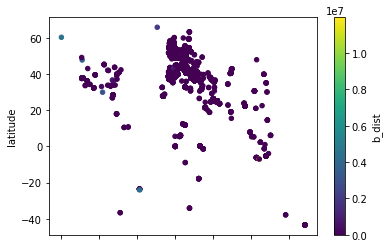

In [36]:
df_noDupl_dist_sp.plot.scatter(x='longitude',y='latitude', c='b_dist',colormap='viridis')

In [110]:
# Clustering to help detect outliers

In [392]:
# lol = df_noDupl_dist_sp[df_noDupl_dist_sp.device_id=='0036AF1D-E140-465B-8859-4F4A88D4F207']
# lol.head()

In [391]:
# X = lol.as_matrix(columns=["longitude","latitude"])
# from scipy.spatial.distance import pdist, squareform
# from haversine import haversine
# distance_matrix = squareform(pdist(X, (lambda u,v: haversine(u,v))))

In [390]:
# # DBSCAN
# from sklearn.cluster import DBSCAN
# epsilon =0.2
# db = DBSCAN(eps=epsilon,min_samples=6, metric="precomputed")
# lolitar = db.fit(distance_matrix)
# lolitar.labels_

In [361]:
# # LocalOutliersFactor
# from sklearn.neighbors import LocalOutlierFactor
# clf = LocalOutlierFactor(n_neighbors=2,novelty=True,  contamination=0.1, metric="precomputed")
# y_pred = clf.fit(distance_matrix)
# X_scores = clf.negative_outlier_factor_
# X_scores

In [362]:
# lol['DBSCAN'] = lolitar.labels_
# lol['LOF'] = X_scores

In [363]:
# lol[lol.DBSCAN==5] # exact same latitude longitude !We added these points in the beginning

In [365]:
# plt.scatter(lol['longitude'],lol['latitude'], c=lol['DBSCAN'])
# plt.show()

In [366]:
# plt.title("Local Outlier Factor (LOF)")
# plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# # plot circles with radius proportional to the outlier scores
# radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
# plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
#             facecolors='none', label='Outlier scores')
# # plt.axis('tight')
# # plt.xlim((-5, 5))
# # plt.ylim((-5, 5))

# legend = plt.legend(loc='upper left')
# legend.legendHandles[0]._sizes = [10]
# legend.legendHandles[1]._sizes = [20]
# plt.show()

In [35]:
len(df_noDupl_dist_sp[(df_noDupl_dist_sp.b_dist>1000) & (df_noDupl_dist_sp.a_dist>1000)])

1246

Cluster the datetime events so we can then detect outliers based on IQR of each cluster

In [33]:
# df_noDupl_1dev['sec']
def cluster(data, maxgap):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap*

        >>> cluster([1, 6, 9, 100, 102, 105, 109, 134, 139], maxgap=10)
        [[1, 6, 9], [100, 102, 105, 109], [134, 139]]

        >>> cluster([1, 6, 9, 99, 100, 102, 105, 134, 139, 141], maxgap=10)
        [[1, 6, 9], [99, 100, 102, 105], [134, 139, 141]]

    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

# cluster(lolita['sec_st_ts'].tolist(),5000)

In [34]:
grouped_deviceId = df_noDupl_dist_sp.groupby('device_id')

In [35]:
df_noDupl_dist_sp['time_group']=0

In [36]:
for name, group in grouped_deviceId:
    time_cluster = cluster(group['sec_st_ts'].tolist(),5000)
    for idx,val in enumerate(time_cluster):
        index_time_group = group.loc[group.sec_st_ts.isin(val)].index.values
        df_noDupl_dist_sp.loc[index_time_group,'time_group']=idx

In [37]:
len(df_noDupl_dist_sp)

118689

In [5]:
df_noDupl_dist_sp.head()

In [39]:
df_noDupl_dist_sp.columns

Index(['group_index', 'device_id', 'latitude', 'longitude', 'st_ts',
       'datetime_st_ts', 'sec_st_ts', 'b_dist', 'b_speed', 'a_dist', 'a_speed',
       'time_group'],
      dtype='object')

iteration 1

In [ ]:
df_noDupl_dist_sp_iqr = df_noDupl_dist_sp[['group_index', 'device_id', 'latitude', 'longitude',
                        'datetime_st_ts', 'sec_st_ts', 'b_dist', 'b_speed', 'a_dist', 'a_speed',
       'time_group']].copy()

In [ ]:
df_noDupl_dist_sp_iqr['outlier']=False

In [46]:
for name, group in grouped_deviceId:
    grouped_time = group.groupby('time_group')
    for namey, groupy in grouped_time:
        df_speed = pd.concat([groupy[['b_speed']],groupy[['a_speed']].rename(columns={'b_speed':'a_speed'})], ignore_index=True)
        
        q25 = df_speed['a_speed'].quantile(.25)
        q75 = df_speed['a_speed'].quantile(.75)

        condition = (q75<groupy['b_speed']) & (q75<groupy['a_speed'])
        
        index_speed_group = groupy[condition].index.values
        
        #df_noDupl_dist_sp_iqr.drop(index_speed_group, inplace=True)
        df_noDupl_dist_sp_iqr.loc[index_speed_group, 'outlier']=True

/home/lefteris/Downloads/enter/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [49]:
len(df_noDupl_dist_sp_iqr[df_noDupl_dist_sp_iqr.outlier==False]) # 91549 # 109984 #108692

114874

In [48]:
df_noDupl_dist_sp_iqr[df_noDupl_dist_sp_iqr.outlier!=False]['b_speed'].describe()

count     3815.000000
mean       198.179889
std       1894.732657
min          0.000000
25%          0.315071
50%          2.662237
75%         24.043547
max      71800.079163
Name: b_speed, dtype: float64

In [6]:
df_noDupl_dist_sp_iqr[df_noDupl_dist_sp_iqr.outlier==True]

iteration 2

In [40]:
df_noDupl_dist_sp_iqr_redcard = df_noDupl_dist_sp[['group_index', 'device_id', 'latitude', 'longitude',
                        'datetime_st_ts', 'sec_st_ts', 'b_dist', 'b_speed', 'a_dist', 'a_speed',
       'time_group']].copy()

In [41]:
df_noDupl_dist_sp_iqr_redcard['outlier']=False

In [42]:
for name, group in grouped_deviceId:
    grouped_time = group.groupby('time_group')
    for namey, groupy in grouped_time:
        df_speed = pd.concat([groupy[['b_speed']],groupy[['a_speed']].rename(columns={'b_speed':'a_speed'})], ignore_index=True)
        
       
        maxi = 3*(df_speed['b_speed'].quantile(.75)-df_speed['b_speed'].quantile(.25))+df_speed['b_speed'].quantile(.75)
        mini = df_speed['b_speed'].quantile(.25)-3*(df_speed['b_speed'].quantile(.75)-df_speed['b_speed'].quantile(.25))
        
        index_speed_groupiiis = groupy[(maxi<groupy['b_speed']) & (maxi<groupy['a_speed'])].index.values
        
        #df_noDupl_dist_sp_iqr.drop(index_speed_group, inplace=True)
        df_noDupl_dist_sp_iqr_redcard.loc[index_speed_groupiiis, 'outlier']=True

/home/lefteris/anaconda3/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [43]:
# for name, group in grouped_deviceId:
#     grouped_time = group.groupby('time_group')
#     for namey, groupy in grouped_time:
#         # http://web.pdx.edu/~stipakb/download/PA551/boxplot.html
#         maxi = 3*(groupy['b_speed'].quantile(.75)-groupy['b_speed'].quantile(.25))+groupy['b_speed'].quantile(.75)
#         mini = groupy['b_speed'].quantile(.25)-3*(groupy['b_speed'].quantile(.75)-groupy['b_speed'].quantile(.25))
#         index_speed_groupiiis = groupy[(groupy['b_speed']<mini) | (maxi<groupy['b_speed'])].index.values
        
#         #df_noDupl_dist_sp_iqr_redcard.drop(index_speed_groupi, inplace=True)
#         df_noDupl_dist_sp_iqr_redcard.loc[index_speed_groupiiis, 'outlier']=True

In [44]:
len(df_noDupl_dist_sp_iqr_redcard[df_noDupl_dist_sp_iqr_redcard.outlier==False]) # 108357

117281

In [45]:
df_noDupl_dist_sp_iqr_redcard[df_noDupl_dist_sp_iqr_redcard.outlier==False]['b_speed'].describe()

count    117281.000000
mean         48.838674
std        2838.193939
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.004669
max      678911.091350
Name: b_speed, dtype: float64

In [7]:
df_noDupl_dist_sp_iqr_redcard[df_noDupl_dist_sp_iqr_redcard.outlier==True]

In [47]:
# lol = pd.DataFrame({'a':[1,2,3]})
# lol
# # http://web.pdx.edu/~stipakb/download/PA551/boxplot.html
# lol['a'].quantile(.25)-3*(lol['a'].quantile(.75)-lol['a'].quantile(.25))
# lol.drop(lol[(lol['a']<lol['a'].quantile(.25)) | (lol['a'].quantile(.75)<lol['a'])].index, inplace=True)

### Filter out the speeds that are more than a value as there are still some extreme values

In [48]:
# static definition of outlier speed
outlier_speed_threshold = 80

without_outliers_df = df_noDupl_dist_sp_iqr_redcard[df_noDupl_dist_sp_iqr_redcard.outlier==False]

high_speed_count = len(without_outliers_df[without_outliers_df['b_speed']>outlier_speed_threshold])
print("Data with speed greater than {}m/s: {}".format(outlier_speed_threshold,high_speed_count))

extreme_speed_df = without_outliers_df[without_outliers_df['b_speed']>outlier_speed_threshold]

print("median: {}".format(extreme_speed_df['b_speed'].median()))
extreme_speed_df['b_speed'].describe()

Data with speed greater than 80m/s: 1930
median: 286.10666211423336


count      1930.000000
mean       2916.226200
std       21940.511395
min          80.063186
25%         139.745693
50%         286.106662
75%         648.120502
max      678911.091350
Name: b_speed, dtype: float64

In [49]:
from statsmodels.robust.scale import mad
xt_mad = mad(extreme_speed_df['b_speed'], c=1)

# static definition of greater outlier speed
new_outlier_speed_threshold = outlier_speed_threshold+xt_mad
new_outlier_speed_threshold

254.0819296089565

Flag as outlier whatever is more than the speed threshold plus the mad of the extreme speed distribution

In [50]:
# # flag the points that are of high_speed
df_noDupl_dist_sp_iqr_redcard.loc[df_noDupl_dist_sp_iqr_redcard[
    'b_speed']>new_outlier_speed_threshold, 'outlier']=True
df_noDupl_dist_sp_iqr_redcard.loc[df_noDupl_dist_sp_iqr_redcard[
    'a_speed']>new_outlier_speed_threshold, 'outlier']=True

In [51]:
df_noDupl_dist_sp_iqr_redcard_new = df_noDupl_dist_sp_iqr_redcard[df_noDupl_dist_sp_iqr_redcard.outlier==False]

In [52]:
df_noDupl_dist_sp_iqr_redcard_new.b_speed.describe()

count    115275.000000
mean          1.949046
std          14.221240
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.003514
max         253.928822
Name: b_speed, dtype: float64

Make a dictionary with keys the device ids and values how many outliers

Maybe at this point we should find the nearest neighbours of the flagged data as outliers with high speed in case there are more GPS spikes nearby

In [53]:
b_minusOne_speed_count = len(df_noDupl_dist_sp_iqr_redcard_new[df_noDupl_dist_sp_iqr_redcard_new['b_speed']==-1])
print("Data with minus speed: {}".format(b_minusOne_speed_count))
a_minusOne_speed_count = len(df_noDupl_dist_sp_iqr_redcard_new[df_noDupl_dist_sp_iqr_redcard_new['a_speed']==-1])
print("Data with minus speed: {}".format(a_minusOne_speed_count))

Data with minus speed: 3532
Data with minus speed: 3513


In [54]:
df_noDupl_dist_sp_iqr_redcard_new_noMinus = df_noDupl_dist_sp_iqr_redcard_new[(df_noDupl_dist_sp_iqr_redcard_new.b_speed!=-1) & (df_noDupl_dist_sp_iqr_redcard_new.a_speed!=-1)]

Add the new neighbouring outliers to the dictionary to keep track of numbers

In [55]:
# # drop the rows where the lat and long are the same and the same device id and starting timestamp
# print("After the deletion of outliers based on heuristics:")

# df_noDupl_dist_sp_iqr_redcard_noOutliers = df_noDupl_dist_sp_iqr_redcard[(df_noDupl_dist_sp_iqr_redcard['speed_m/s']!=-1)]
# len(df_noDupl_dist_sp_iqr_redcard_noOutliers)

In [8]:
df_noDupl_dist_sp_iqr_redcard_new_noMinus.head()

### Check the most frequent device id values

In [9]:
df_noDupl_dist_sp_iqr_redcard_new_noMinus['device_id'].value_counts().head(20)

### Plot 1 device on folium with Outlier Analysis

In [60]:
def get_trajectories_folium(df,id_value):
    df_noDupl_1dev = df[df['device_id']==id_value]
    trajectory_points = df_noDupl_1dev.sort_values(by='datetime_st_ts').as_matrix(columns=["latitude","longitude"])
    traj_points_minusOne = df_noDupl_1dev[(df_noDupl_1dev['b_speed']==-1) | (df_noDupl_1dev['a_speed']==-1)].as_matrix(columns=["latitude","longitude"])
    traj_points_outliers = df_noDupl_1dev[df_noDupl_1dev.outlier==True].as_matrix(columns=["latitude","longitude"])
    return trajectory_points, traj_points_minusOne, traj_points_outliers

In [172]:
trajectory_points_with, traj_points_minusOne_with, traj_points_outliers_with = get_trajectories_folium(df_noDupl_dist_sp_iqr_redcard_new_noMinus,'E0644739-73DA-4066-BBB0-CB23734620A5')

/home/lefteris/Downloads/enter/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lefteris/Downloads/enter/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/home/lefteris/Downloads/enter/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [173]:
import folium
map_dev = folium.Map(location=[52.445764, -1.235518],
                    zoom_start = 7)
folium.CircleMarker(trajectory_points_with[0],radius=5,
                popup='start',
                color='blue').add_to(map_dev)
folium.CircleMarker(trajectory_points_with[-1],radius=5,
                popup='end',
                color='purple').add_to(map_dev)

for each in trajectory_points_with:
    if each in traj_points_outliers_with:
        folium.Marker(each, icon=folium.Icon(color='red')).add_to(map_dev)
    elif each in traj_points_minusOne_with:
        folium.Marker(each, icon=folium.Icon(color='blue')).add_to(map_dev)
                      
folium.PolyLine(trajectory_points_with, color="red", weight=2.5, opacity=1).add_to(map_dev)
map_dev

### Plot 1 device on folium without Outlier

In [ ]:
trajectory_points_without, traj_points_minusOne_without, traj_points_outliers_without = get_trajectories_folium(df_noDupl_dist_sp_iqr_redcard_noOutliers,'A0023FC8-0976-4BE5-9994-DCEFC8C92E44')

In [ ]:
import folium
map_dev = folium.Map(location=[52.445764, -1.235518],
                    zoom_start = 7)
folium.CircleMarker(trajectory_points_without[0],radius=5,
                popup='start',
                color='blue').add_to(map_dev)
folium.CircleMarker(trajectory_points_without[-1],radius=5,
                popup='end',
                color='purple').add_to(map_dev)
                      
folium.PolyLine(trajectory_points_without, color="red", weight=2.5, opacity=1).add_to(map_dev)
map_dev

### Plot devcies on folium without Outlier

In [73]:
comp_path = '/home/lefteris/Desktop/trajectories/data/complement/complementics/city=london/year=2018/month=12/day=01/part-00000-2d6bcdf0-bd27-446d-83e9-20cdeceff12d-c000.snappy.parquet'

In [74]:
com_df = pd.read_parquet(comp_path)

In [10]:
com_df.head()

In [76]:
# sort by starting time
com_df.sort_values(by=['timestamp'], ascending=True, inplace=True)

# set the starting time as the df index
com_df.set_index('timestamp',drop=False, inplace=True)

# drop timestamp column
com_df_new = com_df[["device_id","label","latitude","longitude"]]

In [92]:
top_ids = com_df_new['device_id'].value_counts().head(20).index.values.tolist()

In [94]:
import folium
map_dev = folium.Map(location=[52.445764, -1.235518],
                    zoom_start = 7)

device_ids = top_ids
for id_value in device_ids:
    
    df_noDupl_1dev = com_df_new[com_df_new['device_id']==id_value]
    trajectory_points = df_noDupl_1dev.sort_values(by='timestamp').as_matrix(columns=["latitude","longitude"])

    folium.PolyLine(trajectory_points, color="red", weight=2.5, opacity=1).add_to(map_dev)

map_dev

/home/lefteris/anaconda3/envs/sessions/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


### Stay Points 

## Appendix 

In [171]:
def new_trajectories_on_gmap(df, number_top_ids, convert_unix = False):
    df = df[['device_id', 'latitude', 'longitude', 'datetime_st_ts']]
    
    # get the head() highest in values device ids
    uniq_deviceId = list(df['device_id'].value_counts().head(number_top_ids).to_dict().keys())
    
    # get only the rows with the above unique device ids
    df_paths = df[df['device_id'].isin(uniq_deviceId)]

    # declare the center of the map, and how much we want the map zoomed in
    gmap = gmplot.GoogleMapPlotter(df_paths['latitude'].mean(), df_paths['longitude'].mean(), 8)
    
    for deviceId in uniq_deviceId:
        # filter based on device_id
        df_one_path = df_paths[df_paths['device_id']==deviceId].reset_index(drop=True)
        
        # sort by starting time
        df_one_path.sort_values(by=['datetime_st_ts'], ascending=True, inplace=True)
        
        # set the starting time as the df index
        df_one_path.set_index('datetime_st_ts',drop=False, inplace=True)
        
        # add the start coords into single element list
        lista_lat = []
        lista_lng = []
        lista_lat.append(df_one_path.iloc[0].latitude)
        lista_lng.append(df_one_path.iloc[0].longitude)

        # add to gmap
        gmap.scatter( lista_lat, lista_lng, '#94ff00', 
                              size = 20, marker = False )
        gmap.plot(df_one_path.latitude, df_one_path.longitude,'cornflowerblue',  edge_width = 2.5)
        #gmap.marker(df_one_path.iloc[0].latitude, df_one_path.iloc[0].longitude,'cornflowerblue')
        
    # save the trajectory to html
    gmap.draw("{}-trajectories_{}.html".format(number_top_ids, html_name))
    
new_trajectories_on_gmap(df_noDupl_dist_sp_iqr_redcard_new_noMinus,10)

### Export to google maps html 

In [168]:
import matplotlib.pyplot as plt
import gmplot

def df_on_gmap_one_deviceId(df, deviceId, convert_unix = False):
    # filter based on device_id
    df1 = df[df['device_id']==deviceId].reset_index(drop=True)
    
    if convert_unix==True:
        # convert unix to datetime
        convert_unix_columns(df1)
    
    # sort by starting time
    df1.sort_values(by=['st_ts'], ascending=True, inplace=True)
    
    # set the starting time as the df index
    df1.set_index('st_ts',drop=False, inplace=True)

    # add the distance
    df2 = df_distance_2pnts(df1)
    #df2 = df1.copy()
    
    # set the starting time as the df index
    df2.set_index('st_ts',drop=False, inplace=True)
    
    # declare the center of the map, and how much we want the map zoomed in
    gmap = gmplot.GoogleMapPlotter(df2.iloc[0].latitude, df2.iloc[0].longitude, 18)
    gmap.scatter( df2.latitude.to_list(), df2.longitude.to_list(), '#94ff00', 
                      size = 5, marker = False )
    gmap.plot(df2.latitude, df2.longitude,'cornflowerblue',  edge_width = 2.5)
    
    # save the trajectory to html
    gmap.draw("{}_{}.html".format(deviceId,html_name))

    return df2

def trajectories_on_gmap(df, number_top_ids, convert_unix = False):
    # get the head() highest in values device ids
    uniq_deviceId = list(df['device_id'].value_counts().head(number_top_ids).to_dict().keys())
    
    # get only the rows with the above unique device ids
    df_paths = df[df['device_id'].isin(uniq_deviceId)]
    
    if convert_unix==True:
        # reset the index
        df_paths.reset_index(drop=True)
        # convert unix to datetime
        convert_unix_columns(df_paths)

    # declare the center of the map, and how much we want the map zoomed in
    gmap = gmplot.GoogleMapPlotter(df_paths['latitude'].mean(), df_paths['longitude'].mean(), 8)
    
    for deviceId in uniq_deviceId:
        # filter based on device_id
        df_one_path = df_paths[df_paths['device_id']==deviceId].reset_index(drop=True)
        
        # sort by starting time
        df_one_path.sort_values(by=['st_ts'], ascending=True, inplace=True)
        
        # set the starting time as the df index
        df_one_path.set_index('st_ts',drop=False, inplace=True)
        
        # add the start coords into single element list
        lista_lat = []
        lista_lng = []
        lista_lat.append(df_one_path.iloc[0].latitude)
        lista_lng.append(df_one_path.iloc[0].longitude)

        # add to gmap
        gmap.scatter( lista_lat, lista_lng, '#94ff00', 
                              size = 20, marker = False )
        gmap.plot(df_one_path.latitude, df_one_path.longitude,'cornflowerblue',  edge_width = 2.5)
        #gmap.marker(df_one_path.iloc[0].latitude, df_one_path.iloc[0].longitude,'cornflowerblue')
        
    # save the trajectory to html
    gmap.draw("{}-trajectories_{}.html".format(number_top_ids, html_name))
    
# df_on_gmap_one_deviceId(df_noDupl, '28084A06-B879-46A0-B6CD-041C4FECAC33')
# trajectories_on_gmap(df_noDupl,10000)

plot inline a dataframe with one device id

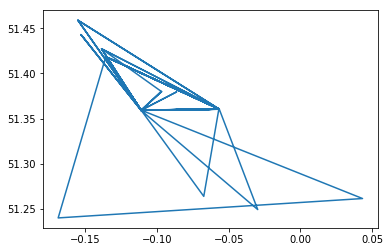

In [129]:
# Enable inline plotting
%matplotlib inline

plt.plot(one_device['longitude'].values, one_device['latitude'].values)

In [89]:
# def unix_to_datetime(number, units='s'):
#     # unix_to_datetime(1545610831949)
#     # unix_to_datetime(1545610831949).time()
#     # unix_to_datetime(1545610831949).minute
#     if units=='s':
#         datetime = pd.to_datetime(round(number/1000), unit=units)
#     elif units =='ms':
#         datetime = pd.to_datetime(number, unit=units)
#     else:
#         raise ValueError ("Values for units: 's' or 'ms'")
#     return datetime

# def convert_unix_columns(df):
#     for index, row in df.iterrows():
#         df.loc[index, 'st_ts']= unix_to_datetime(row['st_ts']).time()
#         df.loc[index, 'nd_ts']= unix_to_datetime(row['nd_ts']).time()
#     #return df